# Machine Learning Models For Solar Cost Datasets

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pandas as pd
import tensorflow as tf
import numpy as np

# import xgboost dependencies
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from lightgbm import LGBMRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

# disable the gpu on mac_m2 so it runs correctly
# https://github.com/keras-team/tf-keras/issues/140
# https://github.com/tensorflow/tensorflow/issues/62361
hw = tf.config.get_visible_devices()
tf.config.set_visible_devices(hw[0])

In [34]:
# import the Utility dataset
utility = 'PGE'
#data_file = "clean_data/df_" + utility + ".csv"
data_file = "/Users/ns96/Documents/ML_Project/df_" + utility + ".csv"

utility_df = pd.read_csv(data_file)
print(utility_df.shape)
utility_df.head()

(148195, 19)


,Utility,Service_City,Service_Zip,Service_County,Technology_Type,System_Size_AC,Storage_Size_kW_AC,Inverter_Size_kW_AC,Mounting_Method,App_Received_Date,Installer_Name,Third_Party_Owned,Electric_Vehicle,Total_System_Cost,Generator_Manufacturer,Inverter_Manufacturer,Generator_Quantity,Inverter_Quantity,Year
0,PGE,KNIGHTSEN,94548,CONTRA COSTA,Solar,2.827,0.0,4.93,Rooftop,2018-10-17,Self-installed,No,No,12000.0,Suntech Power,Enphase,17.0,17.0,2018
1,PGE,DANVILLE,94506,CONTRA COSTA,Solar,12.651,0.0,17.64,Other,2019-08-07,Sky Power,No,No,55200.0,SunPower,SunPower,56.0,56.0,2019
2,PGE,ARROYO GRANDE,93420,SAN LUIS OBISPO,Solar,4.768,0.0,5.00,Rooftop,2019-07-15,Self-installed,No,Yes,20000.0,SolarWorld,SMA America,18.0,1.0,2019
3,PGE,ROCKLIN,95765,PLACER,Solar,2.710,0.0,2.88,Rooftop,2019-01-17,SunPower,No,No,12814.0,SunPower,SunPower,9.0,9.0,2019
4,PGE,ROCKLIN,95765,PLACER,Solar,2.710,0.0,2.88,Rooftop,2019-04-16,SunPower,No,No,12814.0,SunPower,SunPower,9.0,9.0,2019


In [4]:
# extract the year for modeling
# utility_df.App_Received_Date = pd.to_datetime(utility_df.App_Received_Date)
# utility_df['Year'] = utility_df.App_Received_Date.dt.year

In [35]:
# lets see what values of total cost are
utility_df.Total_System_Cost.describe()

count    1.481950e+05
mean     2.965867e+04
std      2.462436e+04
min      7.000000e+03
25%      1.700006e+04
50%      2.504900e+04
75%      3.694200e+04
max      2.995626e+06
Name: Total_System_Cost, dtype: float64

In [ ]:
# reduce the number of cities i.e if less than 200 then just set it to other
city_counts = utility_df.Service_City.value_counts().to_dict()

def check_count(city):
    if city_counts[city] >= 200:
        return city
    else:
        return 'Other'

utility_df['Service_City'] = utility_df['Service_City'].apply(check_count)

In [ ]:
utility_df['Service_City'].value_counts()

In [36]:
# convert zip code to string
utility_df['Service_Zip'] = utility_df['Service_Zip'].astype(int).astype(str).str.zfill(5)
utility_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148195 entries, 0 to 148194
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Utility                 148195 non-null  object 
 1   Service_City            148195 non-null  object 
 2   Service_Zip             148195 non-null  object 
 3   Service_County          148195 non-null  object 
 4   Technology_Type         148195 non-null  object 
 5   System_Size_AC          148195 non-null  float64
 6   Storage_Size_kW_AC      148195 non-null  float64
 7   Inverter_Size_kW_AC     148195 non-null  float64
 8   Mounting_Method         148195 non-null  object 
 9   App_Received_Date       148195 non-null  object 
 10  Installer_Name          148195 non-null  object 
 11  Third_Party_Owned       148195 non-null  object 
 12  Electric_Vehicle        148195 non-null  object 
 13  Total_System_Cost       148195 non-null  float64
 14  Generator_Manufactur

In [37]:
# see how many installers, cities, and zip codes we have
print("Zipcodes:", utility_df.Service_Zip.nunique())
print("Cities:", utility_df.Service_City.nunique())
print("Installers:", utility_df.Installer_Name.nunique())
print("Generator Manufacturer:", utility_df.Generator_Manufacturer.nunique())

Zipcodes: 760
Cities: 632
Installers: 53
Generator Manufacturer: 55


In [9]:
#for now lest drop some columns to make model perform better?
#columns_to_drop = ['Utility', 'Service_Zip', 'Service_County', 'App_Received_Date', 'Inverter_Size_kW_AC', 
#                   'Generator_Manufacturer', 'Inverter_Manufacturer', 'Inverter_Quantity', 'Year']

columns_to_drop = ['Utility', 'Service_Zip', 'Service_County', 'App_Received_Date', 'Inverter_Size_kW_AC', 
                   'Inverter_Manufacturer', 'Inverter_Quantity', 'Year']

#columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date']
#columns_to_drop = ['Utility', 'Service_City', 'App_Received_Date']
#columns_to_drop = ['Utility', 'App_Received_Date']
#columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date', 'Inverter_Size_kW_AC']

utility_df.drop(columns=columns_to_drop, inplace=True)
utility_df.head()

,Service_City,Technology_Type,System_Size_AC,Storage_Size_kW_AC,Mounting_Method,Installer_Name,Third_Party_Owned,Electric_Vehicle,Total_System_Cost,Generator_Manufacturer,Generator_Quantity
0,SAN DIEGO,Solar,3.676,0.0,Rooftop,Tesla,No,No,21709.0,Kyocera,16.0
1,SAN DIEGO,Solar,7.639,0.0,Rooftop,Self-installed,No,No,38000.0,Hanwha,24.0
2,LEMON GROVE,Solar,4.760,0.0,Rooftop,Self-installed,No,No,18000.0,Other,24.0
3,LA MESA,Solar,6.776,0.0,Rooftop,Self-installed,No,No,22000.0,LG,22.0
4,SAN DIEGO,Solar,4.320,0.0,Rooftop,Semper,No,No,15962.0,Sanyo,28.0


In [38]:
# Convert categorical data to numeric with `pd.get_dummies`
cat_columns = utility_df.dtypes[utility_df.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse_output=False)
enc_data = enc.fit_transform(utility_df[cat_columns])
enc_columns = enc.get_feature_names_out().tolist()

encode_df = pd.DataFrame(enc_data, columns=enc_columns)
#display(encode_df.head())

# now lets merge the into the application dataframe then drop original columns
utility_df = utility_df.merge(encode_df, left_index=True, right_index=True)
utility_df = utility_df.drop(columns=cat_columns)

print(utility_df.columns)

utility_df.head()

Index(['System_Size_AC', 'Storage_Size_kW_AC', 'Inverter_Size_kW_AC',
       'Total_System_Cost', 'Generator_Quantity', 'Inverter_Quantity', 'Year',
       'Utility_PGE', 'Service_City_ACAMPO', 'Service_City_AHWAHNEE',
       ...
       'Inverter_Manufacturer_Sanyo', 'Inverter_Manufacturer_Schneider',
       'Inverter_Manufacturer_Sharp', 'Inverter_Manufacturer_SolarBridge',
       'Inverter_Manufacturer_SolarEdge', 'Inverter_Manufacturer_Solaria',
       'Inverter_Manufacturer_Solectria', 'Inverter_Manufacturer_SunPower',
       'Inverter_Manufacturer_Tesla', 'Inverter_Manufacturer_Xantrex'],
      dtype='object', length=3622)


,System_Size_AC,Storage_Size_kW_AC,Inverter_Size_kW_AC,Total_System_Cost,Generator_Quantity,Inverter_Quantity,Year,Utility_PGE,Service_City_ACAMPO,Service_City_AHWAHNEE,...,Inverter_Manufacturer_Sanyo,Inverter_Manufacturer_Schneider,Inverter_Manufacturer_Sharp,Inverter_Manufacturer_SolarBridge,Inverter_Manufacturer_SolarEdge,Inverter_Manufacturer_Solaria,Inverter_Manufacturer_Solectria,Inverter_Manufacturer_SunPower,Inverter_Manufacturer_Tesla,Inverter_Manufacturer_Xantrex
0,2.827,0.0,4.93,12000.0,17.0,17.0,2018,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.651,0.0,17.64,55200.0,56.0,56.0,2019,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.768,0.0,5.00,20000.0,18.0,1.0,2019,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.710,0.0,2.88,12814.0,9.0,9.0,2019,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.710,0.0,2.88,12814.0,9.0,9.0,2019,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
# Split our preprocessed data into our features and target arrays
y = utility_df['Total_System_Cost']
X = utility_df.drop(columns='Total_System_Cost')

## Test the affect of setting the random_state parameter to see the affect of r2

In [ ]:
best_state = -1;
best_r2 = 0
best_mae = 0

for i in range(200):
    print("Testing Random State", i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=i)

    # scale the data
    # Fit the StandardScaler
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    model = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate = 0.07, reg_alpha=1, subsample = 0.8, colsample_bytree=0.9)                     
    #model = RandomForestRegressor(n_jobs = -1)
    #model = LGBMRegressor(metric='mae')
    model.fit(X_train, y_train)

    #Making predictions on the test set
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("R-squared Score:", r2)
    print()

    if r2 > best_r2:
        best_state = i
        best_r2 = r2
        best_mae = mae

# print out the best r2 so far
print("\n------------------------------")
print("Best Random State:", best_state)
print("Best Mean Absolute Error:", best_mae)
print("Best R-squared Score:", best_r2)

Testing Random State 0
Root Mean Squared Error: 18572.78461991773
Mean Absolute Error: 5262.921870276986
R-squared Score: 0.4348993714456435

Testing Random State 1
Root Mean Squared Error: 14135.994599954396
Mean Absolute Error: 5192.329086904947
R-squared Score: 0.6844142184514566

Testing Random State 2
Root Mean Squared Error: 20052.388012709984
Mean Absolute Error: 5256.00646499004
R-squared Score: 0.5565135730874072

Testing Random State 3
Root Mean Squared Error: 16379.026811907128
Mean Absolute Error: 5197.95187818016
R-squared Score: 0.5195159866905785

Testing Random State 4
Root Mean Squared Error: 13217.371137985247
Mean Absolute Error: 5163.89040424139
R-squared Score: 0.6837250884419673

Testing Random State 5
Root Mean Squared Error: 17437.61259875123
Mean Absolute Error: 5220.973208617684
R-squared Score: 0.5140831185842908

Testing Random State 6
Root Mean Squared Error: 17156.707591961836
Mean Absolute Error: 5161.433369719854
R-squared Score: 0.593694877935186

Testi

In [14]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=180)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# set the number of features
number_input_features = X_train.shape[1]
number_input_records = X_train.shape[0]

print("Number of Input Features:", number_input_features)
print("Number of Input Records:", number_input_records)

Number of Input Features: 152
Number of Input Records: 59934


In [23]:
#Basic model Creating an XGBoost regressor
#model = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate = 0.07, reg_alpha=1, subsample = 0.8, colsample_bytree=0.9)
                         
#model = RandomForestRegressor(n_jobs = -1)
#model = LGBMRegressor(metric='mae')

#Training the model on the training data
model.fit(X_train_scaled, y_train)

#Making predictions on the test set
predictions = model.predict(X_test_scaled)

In [24]:
# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Root Mean Squared Error: 14340.25455631452
Mean Absolute Error: 7258.294332538579
R-squared Score: 0.7974427693329639


In [29]:
# specify model and parameter range for grid search CV
# https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv
# https://github.com/albertkklam/XGBRegressor/blob/master/XGBRegressor.ipynb
estimator = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    colsample_bytree = 0.9,
    reg_alpha = 1,
    seed=42
)

parameters = {
    'max_depth': range (5, 10, 1),
    'n_estimators': range(50, 200, 10),
    'learning_rate': [0.1, 0.08, 0.04, 0.01],
    'subsample': [0.7, 0.8, 0.9]
}

# specify the grid search object
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [30]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 11.7 s, sys: 16.1 s, total: 27.9 s
Wall time: 14min 20s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.08, 0.04, 0.01],
                         'max_depth': range(5, 10),
                         'n_estimators': range(50, 200, 10),
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='r2', verbose=True)

In [31]:
# see the best parameters https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv
print(" Results from Grid Search")
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 0.5101531018161263

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 140, 'subsam

In [32]:
# Calculate the mean squared error and R-squared score
model = grid_search.best_estimator_
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Root Mean Squared Error: 14340.25455631452
Mean Absolute Error: 7258.294332538579
R-squared Score: 0.7974427693329639


<BarContainer object of 20 artists>

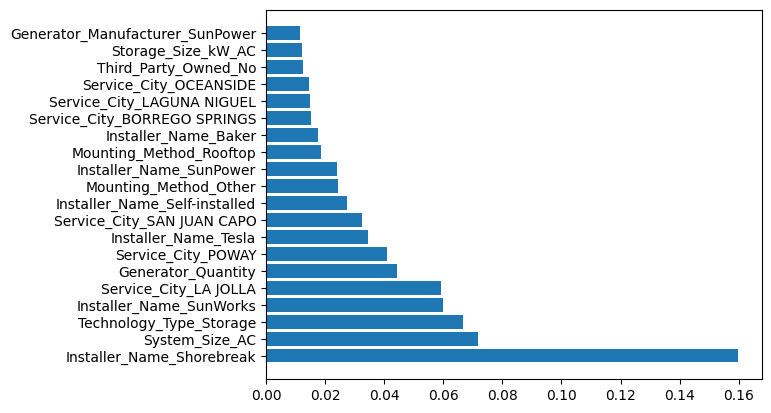

In [33]:
# plot feature importance
n_top_features = 20
sorted_idx = model.feature_importances_.argsort()[::-1]

top_features = X_test.columns[sorted_idx][:n_top_features ].tolist()

plt.barh(X_test.columns[sorted_idx][:n_top_features ], model.feature_importances_[sorted_idx][:n_top_features ])

In [ ]:
# save the model for future use
model_file = "models/xgb_model-" + utility + ".json"
model.save_model(model_file)

## Test a neural network model

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
hidden_nodes_layer1 = number_input_features*2
hidden_nodes_layer2 = number_input_features

activation_function = 'relu'

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation=activation_function))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

In [ ]:
# compile the model
nn.compile(loss='mae', optimizer='rmsprop', metrics=['mse','mae'])

In [ ]:
# Train the model
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

fit_model = nn.fit(X_train_scaled, y_train, epochs=500, batch_size=32, callbacks=[earlyStop])
#fit_model = nn.fit(X_train_scaled, y_train, epochs=100,  batch_size=16)

In [ ]:
#Making predictions on the test set
predictions = nn.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, predictions)
#metric = tf.keras.metrics.R2Score()
#metric.update_state(y_test.to_numpy().reshape(-1,1), predictions)
#r2 = metric.result()

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)